# Long-Term Memory

![Short-term Memory Summarization](images/short-term%20memory%20summarization.png)

## Keeping long-term memories about collaboration 

![Short-term Memory vs. Long-term Memory](images/short-term%20memory%20vs%20long-term%20memory.png)

## LangGraph Store

- Namespaces (User Profile, User Memories, User Preferences)
    - key-value pairs

In [1]:
from langgraph.store.memory import InMemoryStore

namespace = ("evgeny", "facts")

# Save a memory to namespace as key and value
key = "fun_fact_1"

# The value needs to be a dictionary  
value = {
  "fact": "Evgeny likes to ask philosophical questions late at night.",
  "source": "conversation_2024_05_30"
}

# Save the memory
in_memory_store = InMemoryStore()
in_memory_store.put(namespace, key, value)

### retreive all stored memos for namespace

In [2]:
memories = in_memory_store.search(namespace)
memories

[Item(namespace=['evgeny', 'facts'], key='fun_fact_1', value={'fact': 'Evgeny likes to ask philosophical questions late at night.', 'source': 'conversation_2024_05_30'}, created_at='2025-08-16T22:58:13.054675+00:00', updated_at='2025-08-16T22:58:13.054675+00:00', score=None)]

In [3]:
# Metatdata 
memories[0].dict()

{'namespace': ['evgeny', 'facts'],
 'key': 'fun_fact_1',
 'value': {'fact': 'Evgeny likes to ask philosophical questions late at night.',
  'source': 'conversation_2024_05_30'},
 'created_at': '2025-08-16T22:58:13.054675+00:00',
 'updated_at': '2025-08-16T22:58:13.054675+00:00',
 'score': None}

In [4]:
# find by namespace and key
memory = in_memory_store.get(namespace, key)
memory.dict()

{'namespace': ['evgeny', 'facts'],
 'key': 'fun_fact_1',
 'value': {'fact': 'Evgeny likes to ask philosophical questions late at night.',
  'source': 'conversation_2024_05_30'},
 'created_at': '2025-08-16T22:58:13.054675+00:00',
 'updated_at': '2025-08-16T22:58:13.054675+00:00'}

## Chat-bot with short and long memory

### Short-term memory - keeps info about current conversation, uses Checkpoints

### Long-term memory - keeps info about user's profile, preferences, etc., uses MemoryStore

#### Configuration
```
config = {
    "configurable": {
        "thread_id": "1", 
        "user_id": "1"
    }
}
```

#### Store
```
namespace = ("memory", user_id)
key = "user_details"
```



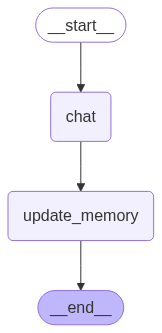

In [5]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage

model = ChatOpenAI(model="gpt-4o-mini")

### Nodes

def chat(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    user_details = store.get(("memory", user_id), "user_details")

    # Extract the actual memory content if it exists and add a prefix
    if user_details:
        # Value is a dictionary with a memory key
        user_details_content = user_details.value.get('memory')
    else:
        user_details_content = "No existing details found."

    # Format the memory in the system prompt
    system_msg = f"""
    You are a helpful assistant with memory capabilities.
    If user-specific memory is available, use it to personalize 
    your responses based on what you know about the user.
    
    Your goal is to provide relevant, friendly, and tailored 
    assistance that reflects the user’s preferences, context, and past interactions.

    If the user’s name or relevant personal context is available, always personalize your responses by:
        – Addressing the user by name (e.g., "Sure, Bob...") when appropriate
        – Referencing known projects, tools, or preferences (e.g., "your MCP  server typescript based project")
        – Adjusting the tone to feel friendly, natural, and directly aimed at the user

    Avoid generic phrasing when personalization is possible. For example, instead of "In TypeScript apps..." say "Since your project is built with TypeScript..."

    Use personalization especially in:
        – Greetings and transitions
        – Help or guidance tailored to tools and frameworks the user uses
        – Follow-up messages that continue from past context

    Always ensure that personalization is based only on known user details and not assumed.
    
    The user’s memory (which may be empty) is provided as: {user_details_content}
    """
    
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def update_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    key = "user_details"
    user_details = store.get(namespace, key)
        
    if user_details:
        user_details_content = user_details.value.get('memory')
    else:
        user_details_content = "No existing details found."

    # Format the memory in the system prompt
    system_msg = f"""
    You are responsible for updating and maintaining accurate user memory to enable personalized responses.

    CURRENT USER DETAILS:
    {user_details_content}

    INSTRUCTIONS:
    1. Carefully review the chat history below.
    2. Identify any new, explicitly stated user information, such as:
        - Personal details (e.g., name, location)
        - Preferences (likes, dislikes)
        - Interests and hobbies
        - Experiences or background
        - Goals and future plans
    3. If no new information is present, do not output anything.
    4. If new information is found:
        - Merge it with the existing memory
        - Format the updated memory as a clear, bulleted list
        - Include only factual, user-stated details
    5. If new information contradicts existing memory, keep the most recent version stated by the user.

    Important:
    - Do NOT include summaries like "no update needed".
    - ONLY return output when actual new user information is added.

    Your final output should either be a clean, updated bulleted list — or nothing at all.
    """
    
    new_memory = model.invoke([SystemMessage(content=system_msg)] + state['messages'])

    if new_memory.content.strip():
        store.put(namespace, key, {"memory": new_memory.content})


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("update_memory", update_memory)
builder.add_edge(START, "chat")
builder.add_edge("chat", "update_memory")
builder.add_edge("update_memory", END)

long_term_memory = InMemoryStore()
short_term_memory = MemorySaver()

graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# start a new conversation
thread = {"configurable": {"thread_id": "1", "user_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="""
Hey, how are you? I am Evgeny, I am a software engineer and I need your help with my project. 
This is a TaskManager Java Spring Boot application.
""")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================


Hey, how are you? I am Evgeny, I am a software engineer and I need your help with my project. 
This is a TaskManager Java Spring Boot application.

================================== Ai Message ==================================

Hi Evgeny! I'm doing well, thanks for asking. It's great to meet you! Your TaskManager Java Spring Boot application sounds interesting. How can I assist you with your project today?


In [7]:
user_id = thread["configurable"]["user_id"]
namespace = ("memory", user_id)
key = "user_details"
memory = long_term_memory.get(namespace, key)
memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_details',
 'value': {'memory': '- Name: Evgeny\n- Occupation: Software Engineer\n- Current Project: TaskManager Java Spring Boot application'},
 'created_at': '2025-08-17T14:31:53.841089+00:00',
 'updated_at': '2025-08-17T14:31:53.841089+00:00'}

let's start another thread

In [8]:
# start a new conversation
thread = {"configurable": {"thread_id": "2", "user_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="""
How can I set up security configurations?
""")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================


How can I set up security configurations?

================================== Ai Message ==================================

Sure, Evgeny! Setting up security configurations in your TaskManager Java Spring Boot application typically involves using Spring Security. Here's a high-level overview to get you started:

1. **Add Dependencies**: Make sure to include Spring Security in your `pom.xml`. If you haven't done that yet, you can add:

   ```xml
   <dependency>
       <groupId>org.springframework.boot</groupId>
       <artifactId>spring-boot-starter-security</artifactId>
   </dependency>
   ```

2. **Configure Security**: Create a security configuration class. You can extend `WebSecurityConfigurerAdapter` and override the necessary methods. For example:

   ```java
   import org.springframework.context.annotation.Configuration;
   import org.springframework.security.config.annotation.web.builders.HttpSec

In [9]:
user_id = thread["configurable"]["user_id"]
namespace = ("memory", user_id)
key = "user_details"
memory = long_term_memory.get(namespace, key)
memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_details',
 'value': {'memory': 'No new information to update.'},
 'created_at': '2025-08-17T14:35:08.884559+00:00',
 'updated_at': '2025-08-17T14:35:08.884559+00:00'}

## LangGraph Studio

url: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024

prompt1: Hey, how are you? I am Evgeny, I am a software engineer and I need your help with my project. This is a TaskManager Java Spring Boot application.

prompt2: How can I set up security configurations?
